We import first the libraries we need to perform  our work.

   - visualization libraries:  matplotlib and seaborn to view cell images and plot some graphs.
   - iPython widgets to show progress bars for lengthy operations
   - basic python os provides a way of using operating system dependent functionality.  
   - Also use  math functionality.
   - numpy and random to manipulate arrays and generate random numbers.
   - scikit-image, skimage, to read cell image files and process them as required.
   - scikit-learn, sklearn, to carry feature engineering, model fitting and hyperparameter searching.


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
%matplotlib inline
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display

from os import listdir, path
from math import floor

import numpy as np
import random

# set random seeds to aid reproducibility
random.seed(22)
np.random.seed(22)

from skimage import io, color
from skimage.transform import resize

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold


The following are just some constants and functions that are used throughout the notebook.

In [3]:
# We define the path of the data
malaria_dataset_path = '/home/rosebandolo/Documents/aims program/Data_science/Projects_Description/03_Malaria_Diagnosis_Data-20191218T192819Z-001/03_Malaria_Diagnosis_Data/cell_images'
parasitized_dir = 'Parasitized'
uninfected_dir = 'Uninfected'
default_ext = '.npy'

def initialize_progress_bar(max_count):
    '''
        Initializes a progress bar with range from
        0 to max_count and returns it.
        
        By setting the value of the progress bar
        returned one can visualise the progress of 
        lengthy processes.
    '''
    
    f = IntProgress(min=0, max=max_count) # instantiate the bar
    display(f)  # display the bar
    f.value = 0
    return f

def save_data(data, save_file_path, data_type='float32'):
    '''
        Convert the contents of the numpy array specified 
        in data to the data type specified in data_type, 
        by default float32, and then save to disk in the 
        path specified in save_file_path.
    '''
    
    print('Saving file {0}...'.format(save_file_path))
    data = data.astype(data_type)
    np.save(save_file_path, data, allow_pickle=False, fix_imports=False)
    print('Done.')
    return data

def load_data(file_path):
    '''
        Load a numpy array from the file located at 
        file_path and return it.
    '''
    
    data = np.load(file_path)
    return data

# Malaria Dataset

The dataset contains a total of 27,558 cell images. The cell images are organized into two folders, parasitized and uninfected, with 13,799 cell images in each. 



## Visualise Parasitized vs Uninfected Cells

Here we want to visualise the first ten cell images from each of the parasitized and uninfected folders to get an idea of what these images look like.

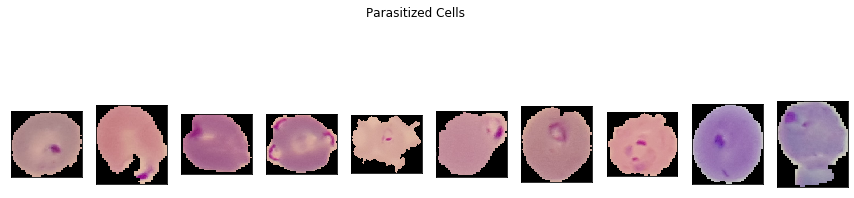

In [6]:
def show_sample_cells(cell_type, num_cells=10, greyscale=False, resize_image=False):
    fig, axes = plt.subplots(1, num_cells, figsize=(15,4))
    fig.suptitle('{0} Cells{1}{2}'.format(cell_type, 
                                          ' - Greyscale' if greyscale else '',
                                          ' - 50x50' if resize_image else ''))
    for idx, f in enumerate(listdir(path.join(malaria_dataset_path, cell_type))[:10]):
        cell_image = io.imread(path.join(malaria_dataset_path, cell_type, f))
        if resize_image:
            cell_image = resize(cell_image, (50, 50, cell_image.shape[2]), mode='reflect')
        if greyscale:
            cell_image = color.rgb2grey(cell_image)
            axes[idx].imshow(cell_image, cmap='gray')
        else:
            axes[idx].imshow(cell_image)
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        
show_sample_cells(parasitized_dir)

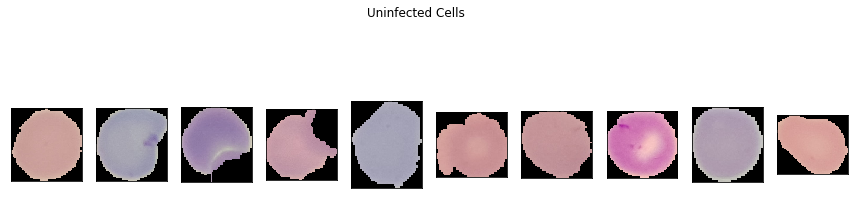

In [7]:
show_sample_cells(uninfected_dir)

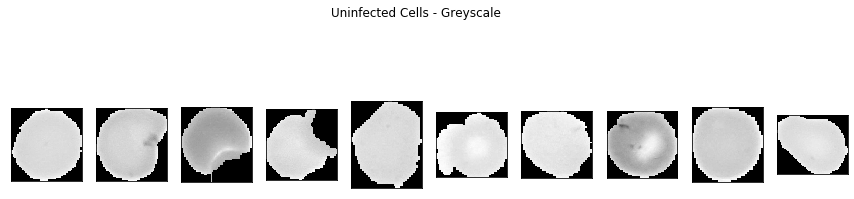

In [8]:
show_sample_cells(uninfected_dir, num_cells=10, greyscale=True, resize_image=False)

## Feature Engineering
Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Feature engineering is fundamental to the application of machine learning, and is both difficult and expensive.

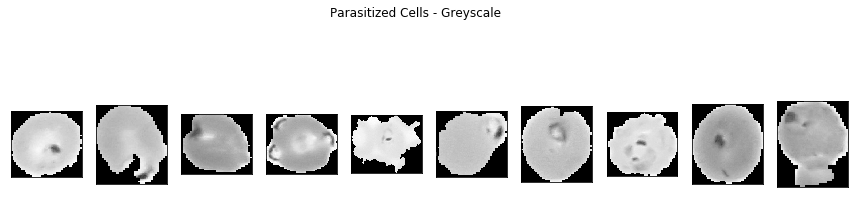

In [9]:
show_sample_cells(parasitized_dir, greyscale=True)

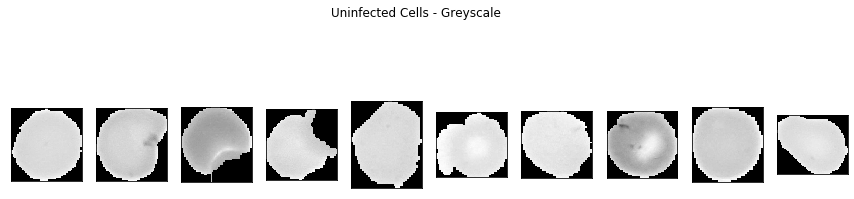

In [10]:
show_sample_cells(uninfected_dir, greyscale=True)

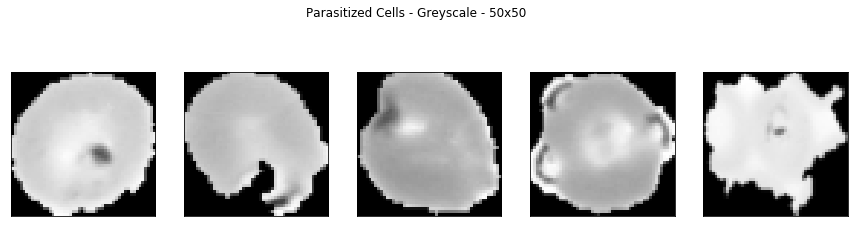

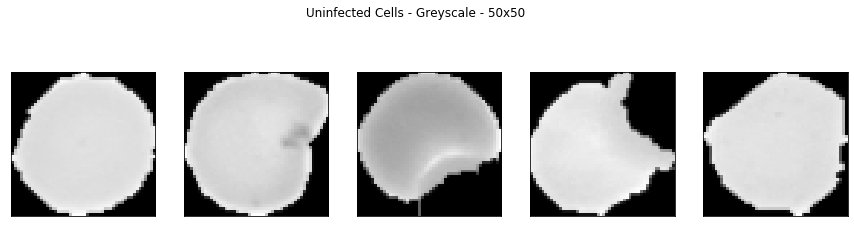

In [13]:
show_sample_cells(parasitized_dir, greyscale=True, resize_image=True)
show_sample_cells(uninfected_dir, greyscale=True, resize_image=True)

## Extracting Distribution of Colours in an Image

## Processing Malaria Dataset

Since the malaria dataset is made up of 27,598 individual image files we want to process them once and store 
the intermediate and final results as large NumPy arrays. These NumPy arrays can then be saved to disk and
loaded much more efficiently when required instead of accessing thousands of individual files.

The load_histnorm_data function below takes care of processing all image files present in the malaria 
dataset folder specified. Each image is resized to 50x50 pixels using the resize_cell_images function, 
converted to greyscale using the greyscale_cell_images function and a normalized histogram of colours
computed using the histnorm_cell_images function. At each stage, intermediate NumPy array files are saved 
as required to speed up loading in the future.


## DownSampling

In [26]:


def resize_cell_images(cell_images_path):
    cell_image_files = listdir(cell_images_path)# is used to get the list of all files and directories in the specified directory. 
    cell_image_files = [f for f in cell_image_files if f.endswith('.png')]
    cell_image_files.sort()
    
    num_cell_images = len(cell_image_files)
    f = initialize_progress_bar(num_cell_images)
    data = np.zeros((num_cell_images,50,50,3))
    for idx, cell_image_file in enumerate(cell_image_files):
        cell_image = io.imread(path.join(cell_images_path, cell_image_file))
        cell_image_resized = resize(cell_image, (50, 50, cell_image.shape[2]), mode='reflect')
        data[idx] = cell_image_resized
        f.value += 1
    data = data.astype('float32')
    return data

## Conversion to Grey Scale

In [22]:
def greyscale_cell_images(data):
    f = initialize_progress_bar(data.shape[0])
    gs_data = np.zeros((data.shape[0],50,50))
    for idx, cell_image in enumerate(data):
        gs_data[idx] = color.rgb2grey(cell_image)
        f.value += 1
    gs_data = gs_data.astype('float32')
    return gs_data

## Removing the Colour and Binarilization

In [23]:
def histnorm_cell_images(data):
    f = initialize_progress_bar(data.shape[0])
    hn_data = np.zeros((data.shape[0],10))
    for idx, cell_image in enumerate(data):
        # range starts from 0.1 to eliminate all black background, value 0
        counts, bins = np.histogram(cell_image, bins=10, range=(0.1,1))
        hn_data[idx] = counts / np.sum(counts)
        f.value += 1
    hn_data = hn_data.astype('float32')
    return hn_data

## Load Histnorm Data

In [24]:
def load_histnorm_data(cell_types):    
    print('Loading {0}...'.format(cell_types))
    
    histnorm_data_file_path = path.join(malaria_dataset_path, ''.join(['hn_', cell_types, default_ext]))
    if path.isfile(histnorm_data_file_path):
        print('Loading histnorm data...')
        histnorm_data = load_data(histnorm_data_file_path)
    else:
        greyscaled_cell_images_data_file_path = path.join(malaria_dataset_path, ''.join(['gs_', cell_types, default_ext]))
        if path.isfile(greyscaled_cell_images_data_file_path):
            print('Loading greyscaled cell images...')
            greyscaled_cell_images_data = load_data(greyscaled_cell_images_data_file_path)
        else:
            resized_cell_images_data_file_path = path.join(malaria_dataset_path, ''.join(['rs_', cell_types, default_ext]))
            if path.isfile(resized_cell_images_data_file_path):
                print('Loading resized cell images...')
                resized_cell_images_data = load_data(resized_cell_images_data_file_path)
            else:
                print('Resizing cell images...')
                resized_cell_images_data = resize_cell_images(path.join(malaria_dataset_path, cell_types))
                resized_cell_images_data = save_data(resized_cell_images_data, resized_cell_images_data_file_path)
                
            print('Greyscaling cell images...')
            greyscaled_cell_images_data = greyscale_cell_images(resized_cell_images_data)
            greyscaled_cell_images_data = save_data(greyscaled_cell_images_data, greyscaled_cell_images_data_file_path)
            
        print('Histnorming cell images...')
        histnorm_data = histnorm_cell_images(greyscaled_cell_images_data)
        histnorm_data = save_data(histnorm_data, histnorm_data_file_path)
        
    return histnorm_data

# Visualising the Normalized Colour Histogram Data

In [25]:
def plot_data_scatter(parasitized_data, uninfected_data):
    if (
         parasitized_data.shape[1] >= 2 and
         uninfected_data.shape[1] >= 2
       ):
        # plot top two components
        plt.scatter(parasitized_data[:,0],
                    parasitized_data[:,1],
                    color='navy',
                    alpha=0.5,
                    label='Parasitized')
        plt.scatter(uninfected_data[:,0],
                    uninfected_data[:,1],
                    color='darkorange',
                    alpha=0.5,
                    label='Uninfected')
        plt.legend()

    if (
         parasitized_data.shape[1] >= 3 and
         uninfected_data.shape[1] >= 3
       ):
        # plot top three components
        fig = plt.figure(figsize=(9,5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(parasitized_data[:,0],
                   parasitized_data[:,1],
                   parasitized_data[:,2],
                   color='navy',
                   alpha=0.5,
                   label='Parasitized')
        ax.scatter(uninfected_data[:,0],
                   uninfected_data[:,1],
                   uninfected_data[:,2],
                   color='darkorange',
                   alpha=0.5,
                   label='Uninfected')
        ax.legend()
        
    plt.show()

In [19]:
parasitized_histnorm_data = load_histnorm_data(parasitized_dir)

Loading Parasitized...
Loading histnorm data...


In [20]:
uninfected_histnorm_data = load_histnorm_data(uninfected_dir)

Loading Uninfected...
Resizing cell images...


IntProgress(value=0, max=13779)

Saving file /home/rosebandolo/Documents/aims program/Data_science/Projects_Description/03_Malaria_Diagnosis_Data-20191218T192819Z-001/03_Malaria_Diagnosis_Data/cell_images/rs_Uninfected.npy...
Done.
Greyscaling cell images...


IntProgress(value=0, max=13779)

Saving file /home/rosebandolo/Documents/aims program/Data_science/Projects_Description/03_Malaria_Diagnosis_Data-20191218T192819Z-001/03_Malaria_Diagnosis_Data/cell_images/gs_Uninfected.npy...
Done.
Histnorming cell images...


IntProgress(value=0, max=13779)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Saving file /home/rosebandolo/Documents/aims program/Data_science/Projects_Description/03_Malaria_Diagnosis_Data-20191218T192819Z-001/03_Malaria_Diagnosis_Data/cell_images/hn_Uninfected.npy...
Done.


In [20]:
plot_data_scatter(parasitized_histnorm_data, uninfected_histnorm_data)

NameError: name 'uninfected_histnorm_data' is not defined

## Visualising only these two or three components it is evident that there is no line or 
## lane that can separate this data. So we will need to use a non-linear classifier such
## as an SVM with an RBF kernel to discriminate between parasitized and uninfected cell images.

In [24]:
def _add_class(data, positive_class=False):    
    if positive_class:
        new_data = np.ones((data.shape[0], data.shape[1]+1))
    else:
        new_data = np.zeros((data.shape[0], data.shape[1]+1))
    new_data[:,:-1] = data[:,:]
    return new_data

In [25]:
def _create_training_testing_split(parasitized_class_data, uninfected_class_data, training=0.8):
    '''
        training: default to 80% of data
        testing: remaining data
    '''
    
    # equal count of parasitized and uninfected records in the malaria dataset
    assert parasitized_class_data.shape[0] == uninfected_class_data.shape[0]
    
    num_samples_in_each_class = parasitized_class_data.shape[0]
    num_features_plus_class = parasitized_class_data.shape[1]
    
    print('{0} samples in each class with {1} features.'.format(num_samples_in_each_class,
                                                                num_features_plus_class-1))
    
    training_count = floor(num_samples_in_each_class * training)
    testing_count = num_samples_in_each_class - training_count
    
    print('Splitting into {0} training and {1} testing samples.'.format(training_count,
                                                                        testing_count))
    
    # Create random training / testing index masks for parasitized / uninfected data
    # so as to split data randomly into training and testing sets.
    parasitized_testing_indices = random.sample(range(0, num_samples_in_each_class), testing_count)
    parasitized_training_mask = np.ones(num_samples_in_each_class, dtype=bool)
    parasitized_training_mask[parasitized_testing_indices] = False
    uninfected_testing_indices = random.sample(range(0, num_samples_in_each_class), testing_count)
    uninfected_training_mask = np.ones(num_samples_in_each_class, dtype=bool)
    uninfected_training_mask[uninfected_testing_indices] = False
    
    # creating training data set
    training_data = np.zeros((training_count*2, num_features_plus_class))
    training_data[:training_count,:] = parasitized_class_data[parasitized_training_mask]
    training_data[training_count:,:] = uninfected_class_data[uninfected_training_mask]
    
    testing_data = np.zeros((testing_count*2, num_features_plus_class))
    testing_data[:testing_count,:] = parasitized_class_data[~parasitized_training_mask]
    testing_data[testing_count:,:] = uninfected_class_data[~uninfected_training_mask]
    
    # shuffle rows
    np.random.shuffle(training_data)
    np.random.shuffle(testing_data)
    
    return training_data, testing_data

In [26]:
def _create_training_testing_data():
    print('Creating training and testing data files...')
        
    print('Loading histnormed data...')
    parasitized_histnorm_data = load_histnorm_data(parasitized_dir)
    uninfected_histnorm_data = load_histnorm_data(uninfected_dir)

    print('Extracting features from data...')
    parasitized_class_data = _add_class(parasitized_histnorm_data, positive_class=True)
    uninfected_class_data = _add_class(uninfected_histnorm_data)

    print('Splitting data into training and testing data sets...')
    training_data, testing_data = _create_training_testing_split(parasitized_class_data,
                                                                 uninfected_class_data)
    
    assert np.sum(training_data[:,-1:]) == len(training_data)/2, "Training data is not balanced."
    assert np.sum(testing_data[:,-1:]) == len(testing_data)/2, "Testing data is not balanced."
    
    print('Done.')
    
    return training_data, testing_data

In [27]:





    
def load_datasets():
    training_file_path = path.join(malaria_dataset_path, ''.join(['training', default_ext]))
    testing_file_path = path.join(malaria_dataset_path, ''.join(['testing', default_ext]))
    
    if path.isfile(training_file_path) and path.isfile(testing_file_path):
        print('Loading training and testing data...')
        training_data = load_data(training_file_path)
        testing_data = load_data(testing_file_path)
        print('Done.')
    else:
        training_data, testing_data = _create_training_testing_data()
        
        print('Saving training and testing data sets...')
        training_data = save_data(training_data, training_file_path)
        testing_data = save_data(testing_data, testing_file_path)
        print('Done.')
        
    X_train = training_data[:,:-1]
    y_train = training_data[:,-1:]
    y_train = y_train.reshape([y_train.shape[0],])
    X_test = testing_data[:,:-1]
    y_test = testing_data[:,-1:]
    y_test = y_test.reshape([y_test.shape[0],])
        
    return X_train, y_train, X_test, y_test

# Loading The Images 

In [28]:
X_train, y_train, X_test, y_test = load_datasets()

Creating training and testing data files...
Loading histnormed data...
Loading Parasitized...
Loading histnorm data...
Loading Uninfected...
Loading histnorm data...
Extracting features from data...
Splitting data into training and testing data sets...
13779 samples in each class with 10 features.
Splitting into 11023 training and 2756 testing samples.
Done.
Saving training and testing data sets...
Saving file /home/rosebandolo/Documents/aims program/Data_science/Projects_Description/03_Malaria_Diagnosis_Data-20191218T192819Z-001/03_Malaria_Diagnosis_Data/cell_images/training.npy...
Done.
Saving file /home/rosebandolo/Documents/aims program/Data_science/Projects_Description/03_Malaria_Diagnosis_Data-20191218T192819Z-001/03_Malaria_Diagnosis_Data/cell_images/testing.npy...
Done.
Done.


## 
Hyperparameter Tuning an SVM Model

We will now use a grid search to fit multiple SVM models on the training data to determine the best gamma and C (cost) hyperparameters for an RBF kernel. Instead of a validation set we are going to use cross validation, which will be stratified to ensure a balanced dataset within each fold.

Also, before we fit each model we are going to preprocess the training data to standardize it and transform it using its principal componenets. For this reason we need to use a pipeline.
## Determining Number of Principal Components to Use

Before we perform the grid search let us determine how many principal components we need to cover at least 95% of the variance.


Loading training and testing data...
Done.


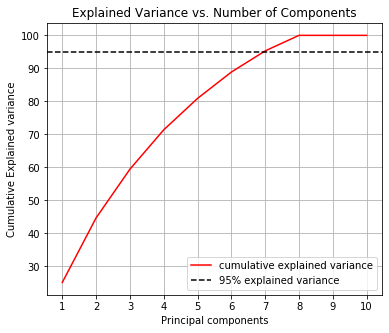

In [29]:
X_train, y_train, X_test, y_test = load_datasets()
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)

pca = PCA()
pca.fit(X_train_stand)
cum_exp_var = pca.explained_variance_ratio_.cumsum()*100
d = [n for n in range(1, len(cum_exp_var)+1)]
plt.figure(figsize=(6, 5))
plt.xticks(d)
plt.grid(True, which='both')
plt.plot(d, cum_exp_var, color = 'red',label='cumulative explained variance')
plt.title('Explained Variance vs. Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% explained variance')
plt.legend(loc='best')
plt.show()


From this chart we determine that 7 principal components explain 95% of the variance.

## Creating a Pipeline to Run a Grid Search

We now create a pipeline so that on each fold we standardize the data and transform it using PCA.
The PCA transformation will be limited to 7 principal components since these explain 95% of the variance.

In [30]:
def perform_grid_search(C_range, gamma_range):
    X_train, y_train, X_test, y_test = load_datasets()
    
    scaler = StandardScaler()
    pca = PCA(n_components=7)
    svc = svm.SVC()
    pipe = Pipeline([('scaler',scaler),
                     ('pca',pca),
                     ('svc',svc)])

    param_grid = {'svc__C': C_range,
                  'svc__gamma': gamma_range}

    search = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=2)
    search.fit(X_train, y_train)
    
    return search

In [31]:
C_range = 10. ** np.arange(-1, 3)
gamma_range = 10. ** np.arange(-1, 3)

search = perform_grid_search(C_range, gamma_range)

Loading training and testing data...
Done.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 13.5min finished



# Best SVM Hyperparameters

We will now plot a heatmap grid of cost vs. gamma to visualise the best performing combination of hyperparameters based on accuracy. Although accuracy is not usually recommended for medical applications, where sensitivity and specificty are more appropriate, for tuning hyperparameters it suffices, especially since the dataset is balanced.


# Performing Grid Search

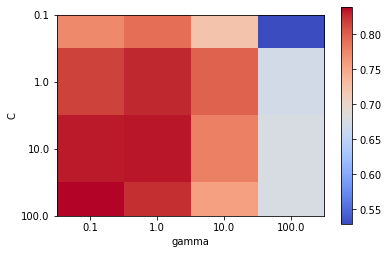

Best accuracy 0.839 using params: {'svc__C': 100.0, 'svc__gamma': 0.1}
Accuracy 95% confidence interval: 0.830 - 0.848


In [32]:
scores = search.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))
plt.figure(figsize=(6, 4))
plt.imshow(scores, cmap=plt.cm.coolwarm)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()
print('Best accuracy {0:.3f} using params: {1}'.format(search.best_score_, search.best_params_))
best_accuracy_std = search.cv_results_['std_test_score'][search.best_index_]
print('Accuracy 95% confidence interval: {0:.3f} - {1:.3f}'.format(search.best_score_ - (best_accuracy_std*2), search.best_score_ + (best_accuracy_std*2)))


The above heatmap shows that within the range of gamma and C combinations explored through grid search, the highest mean accuracy of 84.8% was achieved using gamma=0.1 and C=100. Let us now train the SVM model with RBF kernel using the best performing hyperparameters on the full training set and evaluate its performance on the testing set.

## Fitting Final Model and Evaluating on Testing Set

The final step is to evaluate the SVM model with RBF kernel and hyperparameters set to gamma=1 and C=100 on the testing set to get an estimate of the performance on unseen data.
Training the Best Performing SVM Model on Full Training Set

In [33]:
X_train, y_train, X_test, y_test = load_datasets()

scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

pca = PCA(n_components=7)
pca.fit(X_train_stand)
pca_X_train = pca.transform(X_train_stand)
pca_X_test = pca.transform(X_test_stand)

clf = svm.SVC(kernel='rbf', gamma=1, C=100)
clf.fit(pca_X_train, y_train)

Loading training and testing data...
Done.


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

## Classifying Cell Images in Testing Set

In [34]:
predictions = clf.predict(pca_X_test)

In [35]:
predictions

array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)

Accuracy: 0.833
Matthews CC: 0.665
F1 Score: 0.830
Sensitivity: 0.820
Specificity: 0.841


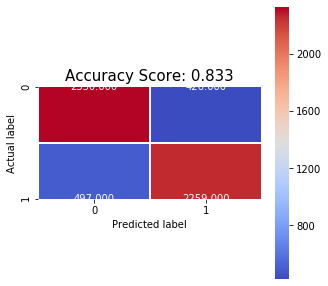

In [36]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
TP, FP, FN, TN = confusion_matrix.ravel()

specificity = TN / (TN + FP) # True Negative Rate

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = plt.cm.coolwarm);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15);

print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions)))
print('Matthews CC: {0:.3f}'.format(metrics.matthews_corrcoef(y_test, predictions)))
print('F1 Score: {0:.3f}'.format(metrics.f1_score(y_test, predictions)))
print('Sensitivity: {0:.3f}'.format(metrics.recall_score(y_test, predictions)))
print('Specificity: {0:.3f}'.format(specificity))